# Quantum Machine Learning with Classiq

Welcome to the "Quantum Machine Learning with Classiq" tutorial. This guide is designed for users already familiar with the fundamentals of the Classiq platform and Quantum Machine Learning (QML) concepts. The aim is to showcase how to implement QML using Classiq. It covers three main methods to implement QML with Classiq:

1. **Using the VQE Primitive**
2. **Using the PyTorch Integration**
3. **Using the QSVM Built-in App**

Each section will provide a brief explanation of the method followed by a simple, illustrative example to demonstrate the integration. These examples are intended to be straightforward to help you get started quickly.

## Table of Contents

1. [Using the VQE Primitive](#Using-the-VQE-Primitive)
   - [Overview](#overview-vqe)
   - [Example Using Classiq](#Example-Using-Classiq)
   - [Summary & Exercise](#summary-exercise-vqe)
   - [Read More](#read-more-vqe)
2. [Using the PyTorch Integration](#Using-the-PyTorch-Integration)
   - [Overview](#overview-pytorch)
   - [Workflow](#Workflow)
   - [Example - Demonstrating PyTorch Integration with Classiq](#example-code-demonstrating-pytorch-integration-with-classiq)
   - [Step 1.1 - Define the quantum model and synthesize it into a quantum program](#step-11---define-the-quantum-model-and-synthesize-it-into-a-quantum-program)
   - [Step 1.2 - Define the Execute and Post-process callables](#step-12---define-the-execute-and-post-process-callables)
   - [Step 1.3 - Create a torch.nn.Module network](#step-13---create-a-torchnnmodule-network)
   - [Step 2 - Choose a dataset, loss function, and optimizer](#step-2---choose-a-dataset-loss-function-and-optimizer)
   - [Step 3 - Train & Evaluate](#step-3-train)
   - [Summary & Exercise](#summary-exercise-pytorch)
   - [Read More](#read-more-pytorch)
8. [Using QSVM Primitive](#Using-QSVM-Primitive)

## Using the VQE Primitive

### Overview <a id="overview-vqe"></a>

The Variational Quantum Eigensolver (VQE) is an algorithm used to find the ground state energy of a Hamiltonian operator, often described by Pauli operators or in the equivalent matrix form. The VQE was proposed by Peruzzo, A., McClean, J., Shadbolt, P. et al. in their paper "A variational eigenvalue solver on a photonic quantum processor" published in *Nature Communications* in 2014. You can find the original paper [here](https://doi.org/10.1038/ncomms5213). \
It follows these steps:

1. **Create a Parameterized Quantum Model**: Design a quantum model, also known as an ansatz, that captures the problem.
2. **Synthesize, Execute & Estimate Expectation Values**: Synthesize the quantum model into a quantum program. Run the quantum program, measure, and calculate the expected value of the Hamiltonian based on this generated program.
3. **Optimize Parameters**: Use a classical optimizer to adjust the quantum program's parameters for better results.
4. **Repeat**: Continue this process until the algorithm converges to a solution or reaches a specified number of iterations.

For more details, refer to the following review article:\
Cerezo, M., Arrasmith, A., Babbush, R., et al. (2021). "Variational quantum algorithms" in *Nature Reviews Physics*, 3, 625–644. [https://doi.org/10.1038/s42254-021-00348-9](https://doi.org/10.1038/s42254-021-00348-9) and the corresponding preprint [arXiv:2104.02281](https://arxiv.org/abs/2104.02281).

### Example Using Classiq

Let's start with a simple example by creating a VQE algorithm that estimates the minimal eigenvalue of the following 2x2 Hamiltonian:

<body><center>
$ H = \frac{1}{2}I + \frac{1}{2}Z - X = \begin{bmatrix} 1 & -1 \\ -1 & 0 \end{bmatrix} $
</center><body>

Now, define the Hamiltonian using a `PauliTerm` list:

In [1]:
from typing import List

from classiq import *

HAMILTONIAN = QConstant(
    "HAMILTONIAN",
    List[PauliTerm],
    [PauliTerm([Pauli.I], 0.5), PauliTerm([Pauli.Z], 0.5), PauliTerm([Pauli.X], -1)],
)

For a single qubit problem, using the U-gate (also known as the U3-gate) allows us to capture any rotation on the Bloch sphere. This includes the state with the minimal energy with respect to our Hamiltonian.

<details>
<summary> NOTE on U-gate</summary>
    
The single-qubit gate applies phase and rotation with three Euler angles.

Matrix representation:

$$
U(\gamma,\phi,\theta,\lambda) = e^{i\gamma}\begin{pmatrix}
\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\
e^{i\phi}\sin(\frac{\theta}{2}) & e^{i(\phi+\lambda)}\cos(\frac{\theta}{2}) \\
\end{pmatrix}
$$

Parameters:

- `theta`: `CReal`
- `phi`: `CReal`
- `lam`: `CReal`
- `gam`: `CReal`
- `target`: `QBit`
</details>

In [2]:
@qfunc
def main(q: Output[QBit], angles: CArray[CReal, 3]) -> None:
    allocate(1, q)
    U(angles[0], angles[1], angles[2], 0, q)

To seamlessly harness the power of VQE, a classical execution function called `cmain` will be used. In the `cmain` function, it is specified that the VQE primitive is being used, and all the parameters are initialized:

In [3]:
@cfunc
def cmain() -> None:
    res = vqe(
        hamiltonian=HAMILTONIAN,
        maximize=False,
        initial_point=[],  # Must be initialized for some optimizers
        optimizer=Optimizer.COBYLA,  # Constrained Optimization by Linear Approximation
        max_iteration=1000,
        tolerance=0.001,
        step_size=0,  # Must be initialized as none-zero value for some optimizers
        skip_compute_variance=False,
        alpha_cvar=1.0,
    )
    save({"result": res})

Note that for our `cmain` function, we are using the `@cfunc` decorator rather than `@qfunc` as we commonly do in the SDK.

<details>
<summary>Description of VQE Parameters</summary>

The `vqe` function in the `cmain` execution function is configured with the following parameters:

- **hamiltonian**: The Hamiltonian of the system to be minimized. In this case, it is specified as `HAMILTONIAN`.

- **maximize**: A boolean indicating whether to maximize the Hamiltonian's expected value. It is set to `False`, meaning the goal is to minimize the Hamiltonian.

- **initial_point**: The starting point for the optimizer. It is set to an empty list, which means the default initial point will be used. This must be initialized for some optimizers.

- **optimizer**: The classical optimization algorithm used to adjust the parameters of the quantum circuit. 

- **max_iteration**: The maximum number of iterations for the optimizer. It is set to `1000`, indicating that the optimizer will perform up to 1000 iterations.

- **tolerance**: The convergence tolerance for the optimizer. It is set to `0.001`, meaning the optimization will stop if the change in the expected value of the Hamiltonian is less than this value.

- **step_size**: The step size for the optimizer. It is set to `0`, which is required to be initialized as a non-zero value for some optimizers.

- **skip_compute_variance**: A boolean indicating whether to skip the computation of the variance. It is set to `False`, meaning the variance will be computed.

- **alpha_cvar**: The confidence level for the Conditional Value at Risk (CVaR) optimization. It is set to `1.0`, which indicates full confidence in the expected value without considering risk aversion.\
For more details, refer to the following article:
Barkoutsos, Panagiotis Kl. et al. Improving Variational Quantum Optimization using CVaR. Quantum 4, 256 (2020). [https://doi.org/10.22331/q-2020-04-20-256](https://doi.org/10.22331/q-2020-04-20-256)


The `cmain` function then saves the result of the VQE optimization using the `save` function.
</details>


<details>
<summary> Supported Optimizers</summary>

- **ADAM**: Adam and AMSGRAD optimizers.
- **AQGD**: Analytic Quantum Gradient Descent (AQGD) with Epochs optimizer.
- **CG**: Conjugate Gradient optimizer.
- **COBYLA**: Constrained Optimization By Linear Approximation optimizer.
- **L_BFGS_B**: Limited-memory BFGS Bound optimizer.
- **GSLS**: Gaussian-smoothed Line Search.
- **GradientDescent**: The gradient descent minimization routine.
- **GradientDescentState**: State of GradientDescent.
- **NELDER_MEAD**: Nelder-Mead optimizer.
- **NFT**: Nakanishi-Fujii-Todo algorithm.
- **P_BFGS**: Parallelized Limited-memory BFGS optimizer.
- **POWELL**: Powell optimizer.
- **SLSQP**: Sequential Least SQuares Programming optimizer.
- **SPSA**: Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer.
- **QNSPSA**: The Quantum Natural SPSA (QN-SPSA) optimizer.
- **TNC**: Truncated Newton (TNC) optimizer.
- **SciPyOptimizer**: A general Qiskit Optimizer wrapping scipy.optimize.minimize.
- **UMDA**: Continuous Univariate Marginal Distribution Algorithm (UMDA).
</details>

Now let's create the model, specifying that we are using `classical_execution_function=cmain`:

In [4]:
qmod = create_model(main, classical_execution_function=cmain)
write_qmod(qmod, "vqe_primitive")
qprog = synthesize(qmod)

Executing from the Classiq Platform:

In [5]:
show(qprog)

Opening: https://platform.classiq.io/circuit/d7b83b7e-0845-4028-bbdf-5fb375cb0df4?version=0.45.0.dev0%2Bcf1b9b7ccc


And then:

<div style="text-align:center;">
    <img src="https://docs.classiq.io/resources/vqe_execution.gif" alt="vqe_execution.gif"/>
</div>


Or directly from the SDK:

In [6]:
res = execute(qprog)
# res.open_in_ide()
vqe_result = res.result()[0].value

Printing the final results:

In [7]:
print(f"Optimal energy: {vqe_result.energy}")
print(f"Optimal parameters: {vqe_result.optimal_parameters}")
print(f"Eigenstate: {vqe_result.eigenstate}")

Optimal energy: -0.642
Optimal parameters: {'angles_param_0': 2.1295212156236483, 'angles_param_1': 6.295895864534323, 'angles_param_2': -4.57415530979221}
Eigenstate: {'0': (0.4669047011971501+0j), '1': (0.8843076387773657+0j)}


The VQE algorithm outputs the following key results:

- **Optimal energy**: The lowest energy found for the Hamiltonian, representing the ground state energy (minimal eigenvalue).
- **Optimal parameters**: The parameters of the quantum program that achieve the optimal energy, corresponding to rotation angles in the U-gate.
- **Eigenstate**: The quantum state associated with the optimal energy, given as probability amplitudes for the basis states.

More information is collected in the `vqe_result` variable and could be further explored.

For instance, easily plotting the `convergence_graph`:

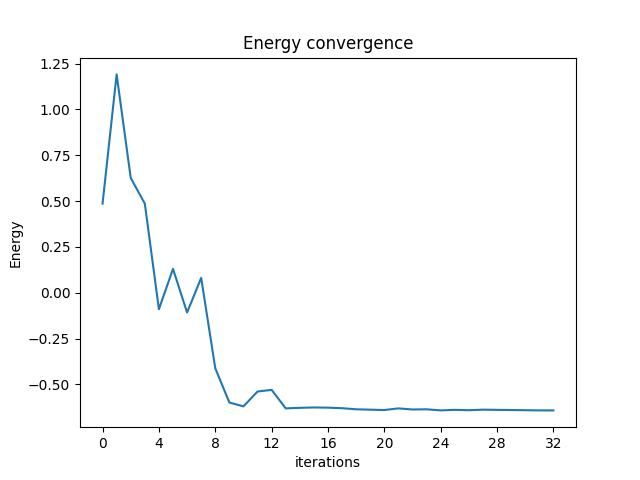

In [8]:
vqe_result.convergence_graph

### Summary & Exercise <a id="summary-exercise-vqe"></a>

We have designed a parameterized quantum circuit capable of capturing a simple Hamiltonian. We defined `cmain` as the classical execution function, including all necessary parameters for VQE execution, and plotted the results.


<details>
<summary>Exercise - Two Qubits VQE</summary>

Now we will practice the implementation of a similar case to the last example, but this time for two qubits, following the Hamiltonian:

$ H = \frac{1}{2}I \otimes I + \frac{1}{2}Z \otimes Z - X \otimes X $

**Use the last example to implement and execute VQE for this Hamiltonian**

Code Skeleton:

```python
HAMILTONIAN = QConstant("HAMILTONIAN", List[PauliTerm], [...]) #TODO: Complete Hamiltonian

@qfunc
def main(...) -> None:
    #TODO: Complete the function according to the instructions, choose simple ansatz.

@cfunc
def cmain() -> None:
    res = vqe(
        HAMILTONIAN,
        False,
        [],
        optimizer=Optimizer.COBYLA,
        max_iteration=1000,
        tolerance=0.001,
        step_size=0,
        skip_compute_variance=False,
        alpha_cvar=1.0,
    )
    save({"result": res})

qmod = create_model(main, classical_execution_function=cmain)
qprog = synthesize(qmod)
show(qprog)
```
<details> 
<summary>Hint</summary>
QArray
</details>
</details>

### Read More <a id="read-more-vqe"></a>

- Algorithms and application tutorials using the VQE primitive:
  - [Molecule Eigensolver](https://docs.classiq.io/latest/explore/applications/chemistry/molecule_eigensolver/molecule_eigensolver/)
  - [H2 Molecule Example](https://docs.classiq.io/latest/explore/community/QClass_2024/Submissions/HW3/bogachan_arslan-HW3_QClass2024/#part-1)
  - [Ground State Solver](https://docs.classiq.io/latest/reference-manual/built-in-algorithms/ground-state-solving/#references)
- Further reading from the reference manual:
  - [Execution Primitives](https://docs.classiq.io/latest/reference-manual/executor/primitives/#vqe)


## Using the PyTorch Integration

### Overview <a id="overview-pytorch"></a>

Classiq integrates with PyTorch, enabling the seamless development of quantum machine learning and hybrid classical-quantum machine learning models. This integration leverages PyTorch's powerful machine learning capabilities alongside quantum computing.

<details>
<summary>Note on PyTorch Installation</summary>

\
To properly install and run PyTorch locally, check [this page](https://pytorch.org/get-started/locally/)

</details>


### Workflow

1. **Model Definition**
    - **1.1**: Define the quantum model and synthesize it into a quantum program.
    - **1.2**: Define the execute and post-process callables.
    - **1.3**: Create a `torch.nn.Module` network.
2. **Choosing Dataset, Loss Function, and Optimizer**
3. **Training the Model**
4. **Testing the Model**


If you're not familiar with PyTorch, it is highly recommended to check out the following pages from their documentation:

<details>
<summary>PyTorch Documentation</summary>

- [Creating Models](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#creating-models)
- [Build the Neural Network](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
- [Optimizing the Model Parameters](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters)
- [Tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)
- [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

</details>


### Example - Demonstrating PyTorch integration with Classiq <a id="example-code-demonstrating-pytorch-integration-with-classiq"></a>

In this example, the PyTorch integration is demonstrated using a simple parameterized quantum model.

One input from the user and one weight are utilized, while using one qubit in the model. The goal of the learning process is to determine the correct angle for an RX gate to perform a "NOT" operation (spoiler: the correct answer is $\pi$).


The dataset `DATALOADER_NOT` will be used, as defined [here](https://docs.classiq.io/latest/reference-manual/built-in-algorithms/qml/qnn/datasets/). \
`DatasetXor` is also available at the link and can be used for further practice.

In [9]:
from classiq import *
from classiq.applications.qnn.datasets import DATALOADER_NOT

for data, label in DATALOADER_NOT:
    print(f"--> Data for training:\n{data}")
    print(f"--> Corresponding labels:\n{label}")

--> Data for training:
tensor([[3.1416],
        [0.0000]])
--> Corresponding labels:
tensor([1., 0.])


This dataset contains two items. The first item indicates no rotation (`0.0000`) and is labeled as 0, indicating the state $|0\rangle$. The second item indicates a rotation of `3.1416` and is labeled as 1, indicating the state $|1\rangle$.

Explnation on creation of PyTorch datasets could be found here: 
- [Creating a Custom Dataset for your files](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)
- [Writing Custom Datasets, DataLoaders and Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

#### Step 1.1 - Define the quantum model and synthesize it into a quantum program
<a id="step-11-define-the-quantum-model-and-synthesize-it-into-a-quantum-program"></a>

The first part of our parameterized quantum model will have an encoding section, which is used to load input data ($|0\rangle$ or $|1\rangle$) into the parameterized quantum model:


In [10]:
@qfunc
def encoding(theta: CReal, q: QArray[QBit]) -> None:
    RX(theta=theta, target=q[0])

The second part will be the `mixing` function, which will include an adjustable parameter for later training the RX gate to act as a NOT gate:

In [11]:
@qfunc
def mixing(theta: CReal, q: QArray[QBit]) -> None:
    RX(theta=theta, target=q[0])

Combining the two functions into our `main` function:

In [12]:
@qfunc
def main(input_0: CReal, weight_0: CReal, res: Output[QArray[QBit]]) -> None:
    allocate(1, res)
    encoding(theta=input_0, q=res)  # Loading input
    mixing(theta=weight_0, q=res)  # Adjustable parameter

Finally, create a model, synthesize it, and display it in the IDE:

In [13]:
model = create_model(main)
write_qmod(model, "qnn_with_pytorch")
quantum_program = synthesize(model)
show(quantum_program)

Opening: https://platform.classiq.io/circuit/87b996e7-a577-4e35-bbef-18bad09ecb3d?version=0.45.0.dev0%2Bcf1b9b7ccc


#### Step 1.2 - Define the Execute and Post-process callables

Before using the quantum layer (QLayer), it is necessary to define the `execute` and `post-processing` functions. These functions are essential for integrating the quantum layer within a PyTorch neural network, as classical layers require classical data as input. This means that only after executing the QLayer (the ansatz) and post-processing the results the data can be further used in other layers of the neural network or be output.

The `execute` function is a straightforward execution. It takes the quantum program (here, the QLayer) and its parameters, and executes it:

In [14]:
from classiq.applications.qnn.types import (
    MultipleArguments,
    ResultsCollection,
    SavedResult,
)
from classiq.execution import execute_qnn
from classiq.synthesis import SerializedQuantumProgram


def execute(
    quantum_program: SerializedQuantumProgram, arguments: MultipleArguments
) -> ResultsCollection:
    return execute_qnn(quantum_program, arguments)

In general, the `post_process` function is needed to prepare the execution results to be outputted or used for loss calculation during the training phase.

In this specific example, it returns the probability of measuring $|0\rangle$. This function assumes that only the differentiation between the single state $|0\rangle$ and all other states is relevant. If a different differentiation is needed, this function should be modified accordingly.

In [15]:
import torch


def post_process(result: SavedResult) -> torch.Tensor:
    """
    Take in a `SavedResult` with `ExecutionDetails` value type, and return the
    probability of measuring |0> which equals the amount of `|0>` measurements
    divided by the total amount of measurements.
    """
    counts: dict = result.value.counts
    # The probability of measuring |0>
    p_zero: float = counts.get("0", 0.0) / sum(counts.values())
    return torch.tensor(p_zero)

Using these functions allows QLayers and PyTorch layers to be properly integrated into the same neural network.

#### Step 1.3 - Create a torch.nn.Module network

The `torch.nn.Module` class with a single `QLayer` defined as follows:

In [16]:
from classiq.applications.qnn import QLayer


class Net(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.qlayer = QLayer(
            quantum_program,  # the quantum program, the result of `synthesize()`
            execute,  # a callable that takes
            # - a quantum program
            # - parameters to that program (a tuple of dictionaries)
            # and returns a `ResultsCollection`
            post_process,  # a callable that takes
            # - a single `SavedResult`
            # and returns a `torch.Tensor`
            *args,
            **kwargs
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.qlayer(x)
        return x


model = Net()

In `self.qlayer = QLayer(...)`, we define the only layer in the neural network, a single QLayer. We specify the previously defined `quantum_program`, `execute`, and `post_process` as arguments for the layer. Finally, we create the neural network and assign it to the variable `model`.

#### Step 2 - Choose a dataset, loss function, and optimizer

For the loss function and optimizer, you will be using [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html), respectively.

In [17]:
import torch.nn as nn
import torch.optim as optim

_LEARNING_RATE = 1

# choosing our data
data_loader = DATALOADER_NOT

# choosing our loss function
loss_func = nn.L1Loss()  # Mean Absolute Error (MAE)

# choosing our optimizer
optimizer = optim.SGD(model.parameters(), lr=_LEARNING_RATE)

<details>
<summary>Available Optimization Algorithms and Loss Functions</summary>

For more details on the available optimization algorithms and a comprehensive list of loss functions in PyTorch, refer to the official documentation:

- [Optimization Algorithms](https://pytorch.org/docs/stable/optim.html#algorithms)
- [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

</details>


#### Step 3 - Train & Evaluate <a id="step-3-train"></a>

Importing `DataLoader`:

In [18]:
from torch.utils.data import DataLoader

A `DataLoader` in PyTorch efficiently iterates over datasets, handling batching, shuffling, and parallel data loading. It streamlines the process of training and evaluating models by managing data efficiently.

Now we are ready to define the training function. \
For this simple example, we will follow a similar loop to the one recommended by PyTorch [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#update-the-weights).


In [19]:
def train(
    model: nn.Module,
    data_loader: DataLoader,
    loss_func: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    epoch: int = 1,  # About 40 Epochs need for full training
) -> None:
    for index in range(epoch):
        print(index, model.qlayer.weight)
        for data, label in data_loader:
            optimizer.zero_grad()

            output = model(data)

            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()

In [20]:
train(model, data_loader, loss_func, optimizer)

0 Parameter containing:
tensor([0.6263], requires_grad=True)


Great! We can observe that our parameter is approximately equal to $\pi$. \
Now we will test our network accuracy using the suggested method [here](https://stackoverflow.com/questions/52176178/pytorch-model-accuracy-test#answer-64838681).

In [21]:
def check_accuracy(model: nn.Module, data_loader: DataLoader, atol=1e-4) -> float:
    num_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():  # Temporarily disable gradient calculation
        for data, labels in data_loader:
            # Let the model predict
            predictions = model(data)

            # Get a tensor of booleans, indicating if each label is close to the real label
            is_prediction_correct = predictions.isclose(labels, atol=atol)

            # Count the amount of `True` predictions
            num_correct += is_prediction_correct.sum().item()
            # Count the total evaluations
            #   the first dimension of `labels` is `batch_size`
            total += labels.size(0)

    accuracy = float(num_correct) / float(total)
    print(f"Test Accuracy of the model: {accuracy*100:.2f}%")
    return accuracy

In [22]:
check_accuracy(model, data_loader)

Test Accuracy of the model: 0.00%


0.0

**The results show an accuracy of 1**, indicating a 100% success rate in performing the required transformation (i.e., the network learned to perform an X-gate). We can further validate this by printing the value of `model.qlayer.weight`, which is a tensor of shape (1,1). After training, this value should be close to $\pi$.

### Summary & Exercise <a id="summary-exercise-pytorch"></a>

In this tutorial, we integrated a quantum layer within a PyTorch neural network, defined the necessary execution and post-processing functions, and trained the model using a simple dataset. We also tested the network's accuracy using a recommended method. To further explore, try experimenting with different quantum circuits, datasets, and optimizers. Intgreating more classic layers or more complex layers should be quite stright forword now for those who have some exprince with PyTorch.

<details>
<summary>Exercise - Training U Gate</summary>

Now for practice, try to implement a similar case to the last example, but this time train the U gate to act as a NOT gate, instead of the Rx gate.  
How many parameters will you have to train?  
What will you have to change to accomplish this?

<details>
<summary>Hint</summary>
    
You will have to adapt only `mixing` and `model`.

</details>
</details>


### Read More 
<a id="read-more-pytorch"></a>

- Algorithms and application tutorials using the PyTorch intgration:
    - [Quantum Autoencoder](https://docs.classiq.io/latest/explore/algorithms/qml/quantum_autoencoder/quantum_autoencoder/)
    - [QGAN](https://docs.classiq.io/latest/explore/algorithms/qml/qgan/qgan_bars_and_strips/)
    - [QNN for the XOR Problem](https://docs.classiq.io/latest/explore/community/QClass_2024/Submissions/HW4/Claudia_Zendejas-Morales_HW4_QClass2024/)
- Further reading from the reference manual:
    - [QNNs with Classiq](https://docs.classiq.io/latest/reference-manual/built-in-algorithms/qml/qnn/)
    - [QLayer](https://docs.classiq.io/latest/reference-manual/built-in-algorithms/qml/qnn/qlayer/)

## Using QSVM Primitive 

Classiq also enables executing classification tasks using the **Quantum Support Vector Machine** (QSVM) module. This module leverages the principles of quantum computing to enhance traditional support vector machine algorithms, offering significant improvements in classification accuracy and efficiency. The QSVM module integrates seamlessly with the Classiq platform, allowing users to implement quantum-enhanced classification models effortlessly. By utilizing quantum kernels, the QSVM can handle complex datasets and capture intricate patterns that may be challenging for classical SVMs, making it a powerful tool for various machine learning applications.



To understand how to use it and explore it further, check the following example: [QSVM with Classiq](https://docs.classiq.io/latest/explore/algorithms/qml/qsvm/qsvm/)